In [ ]:
import struct

path = 'data/09020002.DAT' # Update this to the actual path
data_points = []

with open(path, 'rb') as file: # rb: binary read mode 
    while True:
        data = file.read(2)  # Assuming the data is stored as int16_t (2 bytes)
        if not data:
            break
        value = struct.unpack('<h', data)[0]  # '<' denotes little-endian format, 'h' is int16_t
        data_points.append(value)

print("Data read from file:", data_points)


In [ ]:
import struct

path = 'data/09020002.DAT' # Update this to the actual path
data_points = []

with open(path, 'rb') as file: # rb: binary read mode 
    while True:
        data = file.read(4)  # Assuming the data is stored as int16_t (2 bytes)
        if not data:
            break
        value = struct.unpack('<I', data)[0]  # '<' denotes little-endian format, 'h' is int16_t
        data_points.append(value)

print("Data read from file:", data_points)


In [ ]:
import struct

def read_binary_file(file_path, num_bytes):
    with open(file_path, 'rb') as file:
        data = file.read(num_bytes)
    return data

# Replace 'your_binary_file.dat' with the actual file path
file_path = path
header_size = 8*3  # Replace with the actual header size in bytes
num_bytes_to_read = 16  # Size of a single set of data after the header

# Read the specified number of bytes from the binary file after the header
binary_data = read_binary_file(file_path, header_size + num_bytes_to_read)

# Print the hexadecimal values of the read data
hex_values = ' '.join(f'{byte:02X}' for byte in binary_data)
print(f'Hexadecimal values of the first {num_bytes_to_read} bytes after the header: {hex_values}')

# values = struct.unpack("IIII", binary_data)
# values = struct.unpack(f"{num_bytes_to_read}B", binary_data)

# Manually interpret the data assuming 4-byte (32-bit) values
# "I": unsigned int 


for n in range(0,11): 
    value = struct.unpack("I", binary_data[ 4*n : 4*n + 4])[0]
    # print(value)
    bin = binary_data[ 4*n : 4*n + 4]
    print(bin)



In [ ]:
# confirming the analog values: 
(851/20)*(3.3/4096) # Ground on A0 
(40939/20)*(3.3/4096) # Voltage divider on A1 


In [ ]:
import struct

def read_binary_file(file_path):
    with open(file_path, 'rb') as file:
        data = file.read()
    return data

def bytes_to_binary_string(byte_array):
    return ''.join(format(byte, '08b') for byte in byte_array)

binary = read_binary_file(path)
# Print the raw bytes and their hexadecimal values
print(f"Raw bytes: {binary_data}")
print(f"Hexadecimal values: {' '.join([f'{byte:02X}' for byte in binary_data])}")

# Print the binary representation of each byte
binary_string = bytes_to_binary_string(binary_data)
print(f"Binary values: {binary_string}")

20 0 10


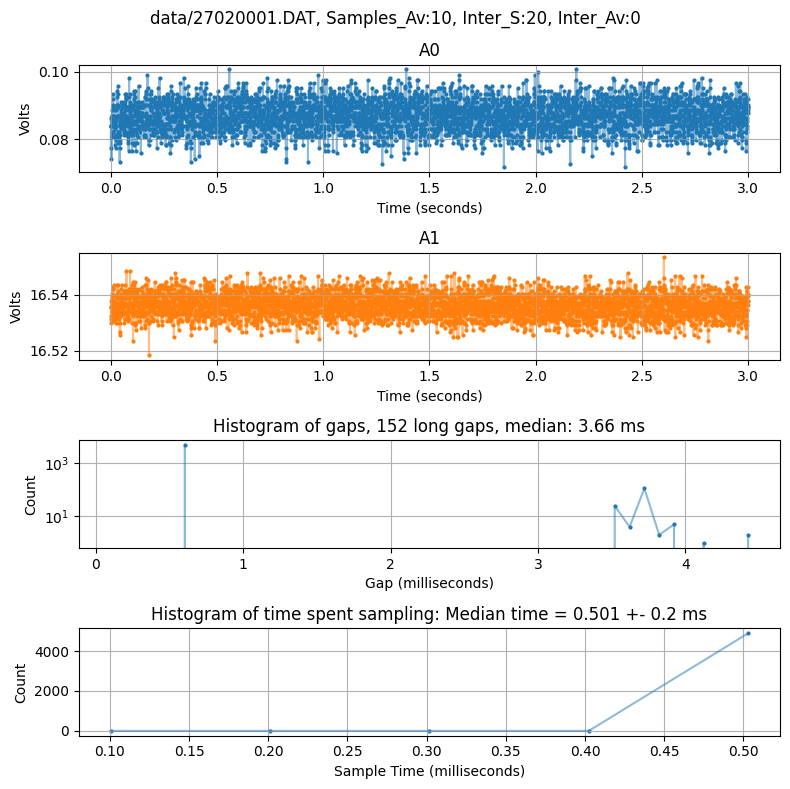

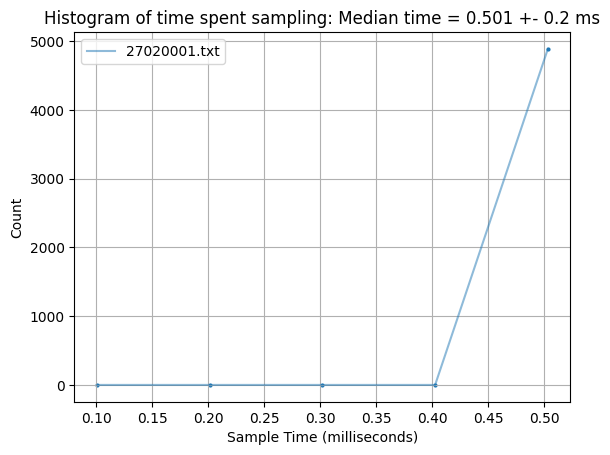

In [2]:
from binary_IRIS import extract_params, quickLook

path = 'data/27020001.DAT' 
t1,t2,v0,v1,s,f,g = extract_params(path)
print(s,f,g)

quickLook(path)
